<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Taxa_de_crescimento_de_estruturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos plotar a função taxa de crescimento de estruturas $f$ e como seu comportamento varia de acordo com os parâmetros: $w_0$, $\Omega_{k0}$ e $\Omega_{m0}$. 

In [96]:
# Bibliotecas:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [98]:
import pyccl as ccl

Primeiramente, manteremos os valores de $\Omega_{k0}$ e $\Omega_{m0}$ fixos de acordo com os valores obtidos pelo Planck e iremos variar $w_0$ entre -1.2 e -0.8 (lembrando que no modelo $\Lambda$CDM temos que $w_0$ = -1).

Lembrando que:

$\Omega_m (a) = \frac{\Omega_{m0} a^{-3}}{\Omega_{m0} a^{-3} + \Omega_{k0} a^{-2} + \Omega_{\Lambda 0}}$,

em que:

$\Omega_{\Lambda 0} = 1 - \Omega_{m0}$.

Logo:

$\Omega_m (a) = \frac{\Omega_{m0} a^{-3}}{\Omega_{m0} a^{-3} + \Omega_{k0} a^{-2} + 1 - \Omega_{m0}}$.

Então, neste primeiro caso consideraremos $\Omega_{m0}$ = 0.30 e $\Omega_{k0}$ = 0.

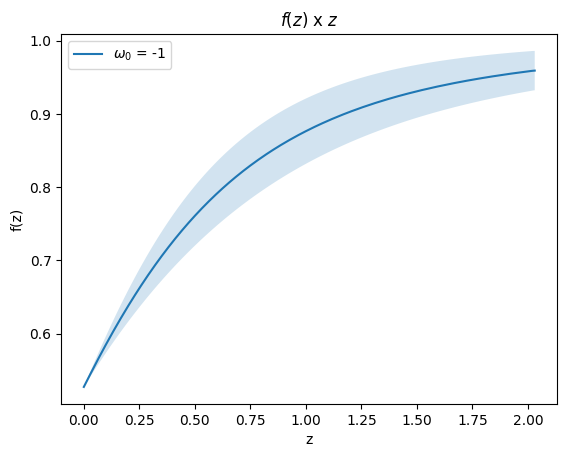

In [110]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)

# definindo w0
w0 = -1
sigw0 = 0.2

# definindo gamma
gamma = 6./11.

# definindo o erro de f
f_1 = (Om0*((1 + z)**3))/( Om0*((1 + z)**3) + ( 1 - Om0 )*( (1 + z)**(3*(1+w0)) ) )
f_2 = (1 - Om0)*( (1+z)**(3*(1 + w0)) ) + Om0*((1 + z)**3)
df = ( (3*(Om0 - 1)*Om0*gamma*((1+z)**(3*(1+w0) + 3))*np.log(1+z) )/(f_2)**2)*((f_1)**(gamma-1))
sig_f = ((df)*sigw0)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\omega_0$ = -1')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2)
plt.legend(loc='upper left')
plt.title('$f(z)$ x $z$')
plt.show()

Agora, vamos manter $w_0$ e $\Omega_{k0}$ fixos em -1 e 0, respectivamente, e variar $\Omega_{m0}$ entre 0.25 e 0.35

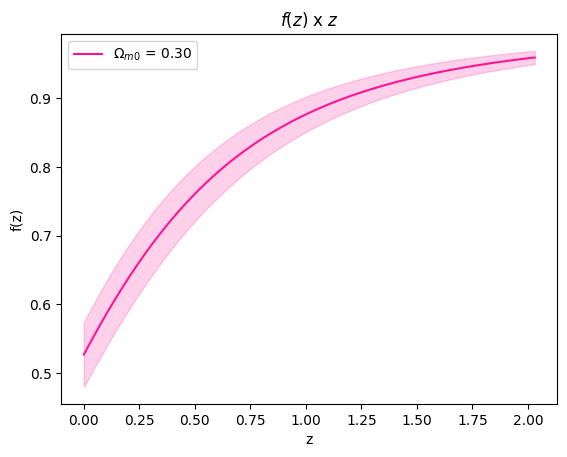

In [111]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
sigOm = 0.05

# definindo w0
w0 = -1

# definindo o erro de f
df1 = gamma*( ((1+z)**3)/f_2 - ( ((1+z)**3)*Om0*( ((1+z)**3) -  (1+z)**(3*(1 + w0)) ) )/( (f_2)**2) )*( (f_1)**(gamma-1) )
sig_f1 = ((df1)*sigOm)

fig, ax = plt.subplots()
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='deeppink')
plt.xlabel('z')
plt.ylabel('f(z)')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='deeppink')
plt.legend(loc='upper left')
plt.title('$f(z)$ x $z$')
plt.show()

Agora, vamos manter $w_0$ e $\Omega_{m0}$ fixos em -1 e 0.30, respectivamente, e variar $\Omega_{k0}$ entre -0.1 e 0.1.

In [114]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30
Ok0 = 0
OL0 = 0.70

# definindo O_m
Om = ( Om0*(a**(-3)) )/( Om0*(a**(-3)) + OL0 + Ok0*(a**(-2)) )
sigOm = 0.05

# definindo w0
w0 = -1